In [1]:
import numpy as np
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)
import matplotlib.pyplot as plt

2023-01-05 21:17:17.625340: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-05 21:17:19.619348: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-05 21:17:19.708891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 21:17:19.709272: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 119.24GiB/s
2023-01-05 21:17:19.709302: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-05 21:17:19.713140: I tensorflow/stream_executor/pl

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images[:10000] / 255.0, test_images[:10000] / 255.0

In [3]:
train_labels = tf.keras.utils.to_categorical(train_labels)[:10000]
test_labels = tf.keras.utils.to_categorical(test_labels)[:10000]

In [4]:
train_images.shape, train_labels.shape

((10000, 32, 32, 3), (10000, 10))

In [5]:
input_layer = tf.keras.layers.Input(shape=(32,32,3), name='input')
conv_1 = tf.keras.layers.Conv2D(32, (3,3), name='conv_1')(input_layer)
max_pool_1 = tf.keras.layers.MaxPooling2D((2,2), name='max_pool_1')(conv_1)
conv_2 = tf.keras.layers.Conv2D(64, (3,3), name='conv_2')(max_pool_1)
max_pool_2 = tf.keras.layers.MaxPooling2D((2,2), name='max_pool_2')(conv_2)
conv_3 = tf.keras.layers.Conv2D(64, (3,3), name='conv_3')(max_pool_2)
gap = tf.keras.layers.GlobalAveragePooling2D(name="gap")(conv_3)
dense_1 = tf.keras.layers.Dense(64, activation ="relu", name="dense_1")(gap)
out = tf.keras.layers.Dense(10, activation ="softmax", name="output")(dense_1)
model = tf.keras.models.Model(input_layer, out)

2023-01-05 21:17:32.392570: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 21:17:32.393112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 21:17:32.393417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 119.24GiB/s
2023-01-05 21:17:32.393524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), 

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 15, 15, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 6, 6, 64)          0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 4, 4, 64)          36928     
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 64)                0     

In [7]:
optimizer = tf.keras.optimizers.Adam()

loss_fn = tf.keras.losses.CategoricalCrossentropy()

train_acc_metric = tf.keras.metrics.CategoricalAccuracy()

In [8]:
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)


val_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
val_dataset = val_dataset.batch(batch_size)

2023-01-05 21:17:36.473070: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 245760000 exceeds 10% of free system memory.
2023-01-05 21:17:36.773059: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 245760000 exceeds 10% of free system memory.


In [9]:
epochs = 20
for epoch in range(epochs):
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y_batch_train, logits)
        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    train_acc = train_acc_metric.result()
    print(f"Training acc over epoch {epoch+1}: {float(train_acc)}")
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

2023-01-05 21:17:53.560613: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 245760000 exceeds 10% of free system memory.
2023-01-05 21:17:53.727468: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-01-05 21:17:54.164268: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2023-01-05 21:17:54.893602: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-05 21:17:55.657438: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


Training loss (for one batch) at step 0: 2.2126
Seen so far: 16 samples
Training loss (for one batch) at step 200: 1.7790
Seen so far: 3216 samples
Training loss (for one batch) at step 400: 1.6179
Seen so far: 6416 samples
Training loss (for one batch) at step 600: 1.6518
Seen so far: 9616 samples
Training acc over epoch 1: 0.28060001134872437
Training loss (for one batch) at step 0: 1.6516
Seen so far: 16 samples


2023-01-05 21:18:01.766506: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 245760000 exceeds 10% of free system memory.


Training loss (for one batch) at step 200: 1.7255
Seen so far: 3216 samples
Training loss (for one batch) at step 400: 1.6246
Seen so far: 6416 samples
Training loss (for one batch) at step 600: 1.5017
Seen so far: 9616 samples
Training acc over epoch 2: 0.41780000925064087
Training loss (for one batch) at step 0: 1.7615
Seen so far: 16 samples


2023-01-05 21:18:07.529889: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 245760000 exceeds 10% of free system memory.


Training loss (for one batch) at step 200: 1.5431
Seen so far: 3216 samples
Training loss (for one batch) at step 400: 1.6859
Seen so far: 6416 samples
Training loss (for one batch) at step 600: 1.4620
Seen so far: 9616 samples
Training acc over epoch 3: 0.4659999907016754
Training loss (for one batch) at step 0: 1.5691
Seen so far: 16 samples
Training loss (for one batch) at step 200: 1.6399
Seen so far: 3216 samples
Training loss (for one batch) at step 400: 1.3560
Seen so far: 6416 samples
Training loss (for one batch) at step 600: 1.0494
Seen so far: 9616 samples
Training acc over epoch 4: 0.5020999908447266
Training loss (for one batch) at step 0: 1.3056
Seen so far: 16 samples
Training loss (for one batch) at step 200: 1.2956
Seen so far: 3216 samples
Training loss (for one batch) at step 400: 1.2165
Seen so far: 6416 samples
Training loss (for one batch) at step 600: 1.3845
Seen so far: 9616 samples
Training acc over epoch 5: 0.5299000144004822
Training loss (for one batch) at s

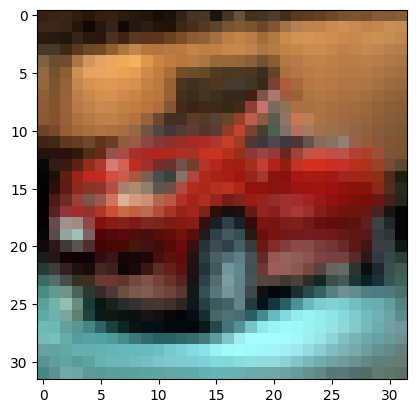

In [24]:
plt.imshow(train_images[45])

In [25]:
pred  = model.predict(np.expand_dims(train_images[45], axis=0))

In [26]:
idx = np.argmax(pred)
print(idx)

1


In [27]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
class_names[idx], pred[0][idx]

('automobile', 0.9754851)

In [28]:
input_img = np.expand_dims(train_images[45], axis=0)
input_img = tf.convert_to_tensor(input_img)

In [29]:
with tf.GradientTape() as tape:
    tape.watch(input_img)
    result = model(input_img)
    max_score = result[0,idx]
grads = tape.gradient(max_score, input_img)
# plot_maps(norm_flat_image(grads[0]), norm_flat_image(input_img[0]))

In [30]:
def norm_flat_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

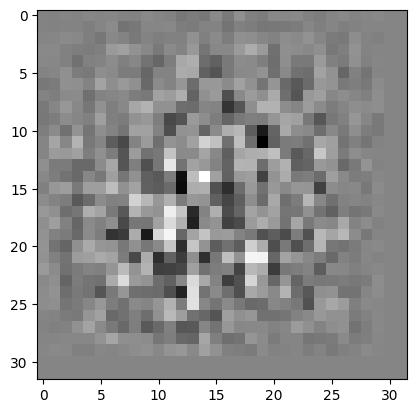

In [31]:
grads_img = norm_flat_image(grads[0]).numpy()
plt.imshow(grads_img, cmap='gray')

In [32]:
norm_input_image = norm_flat_image(input_img[0])

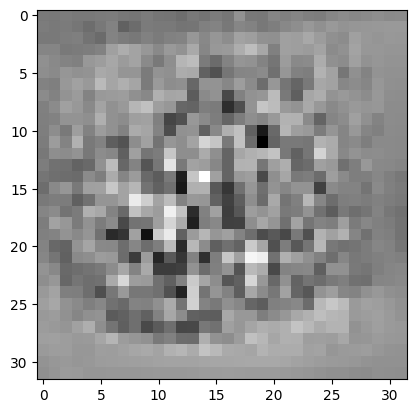

In [33]:
plt.imshow(grads_img*2+norm_input_image/2, cmap="gray")
plt.show()

In [34]:
def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "gray" )
    plt.axis("off")

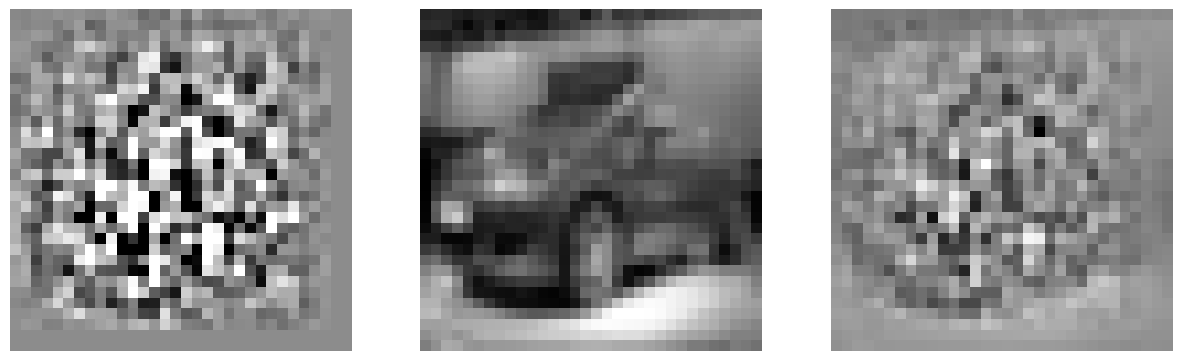

In [35]:
plot_maps(grads_img, norm_input_image)